In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable. Removed the max price on luxury vehicles.  Dropped non-luxury maximum to 250k.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22557.0,0.0,69581.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22198.0,1.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,0.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,0.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 9.0
Last section took: 9.0
(in seconds)


In [5]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

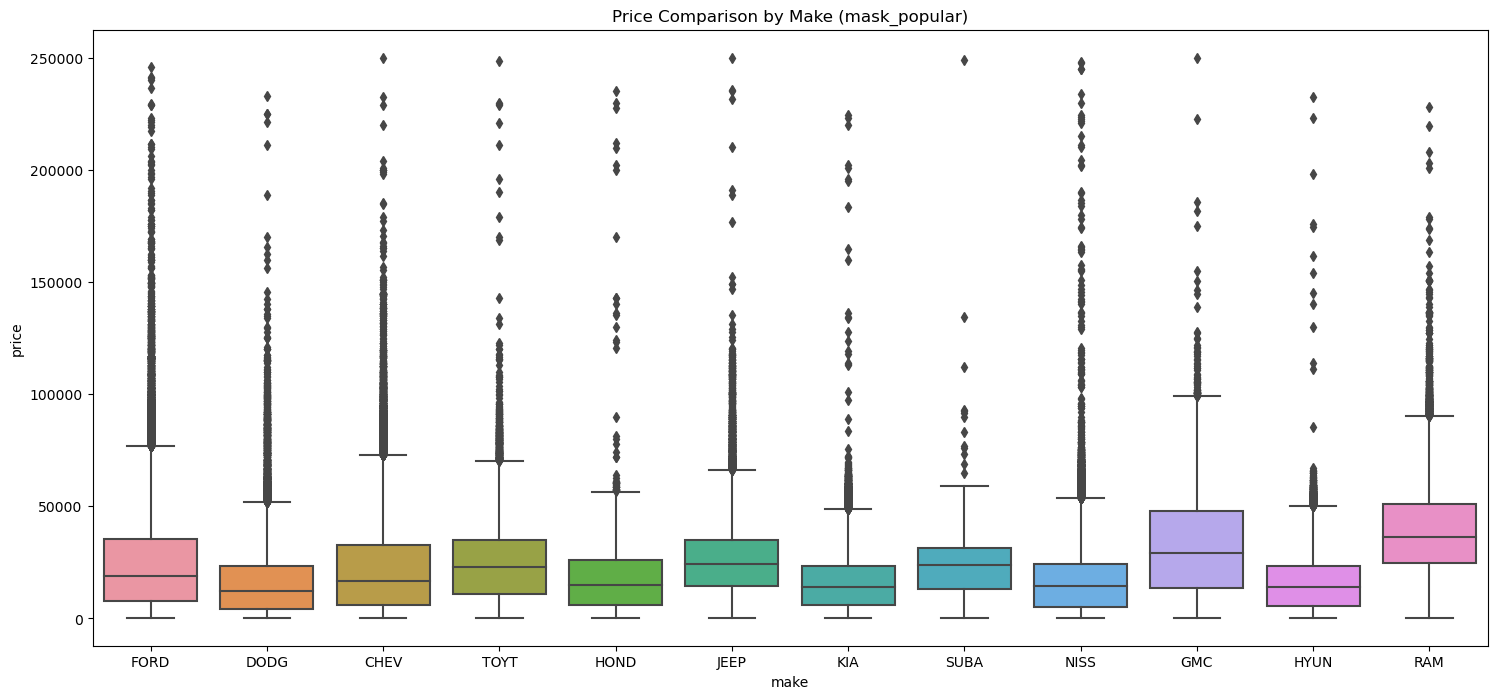

In [6]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_popular])
plt.title("Price Comparison by Make (mask_popular)")
plt.show()

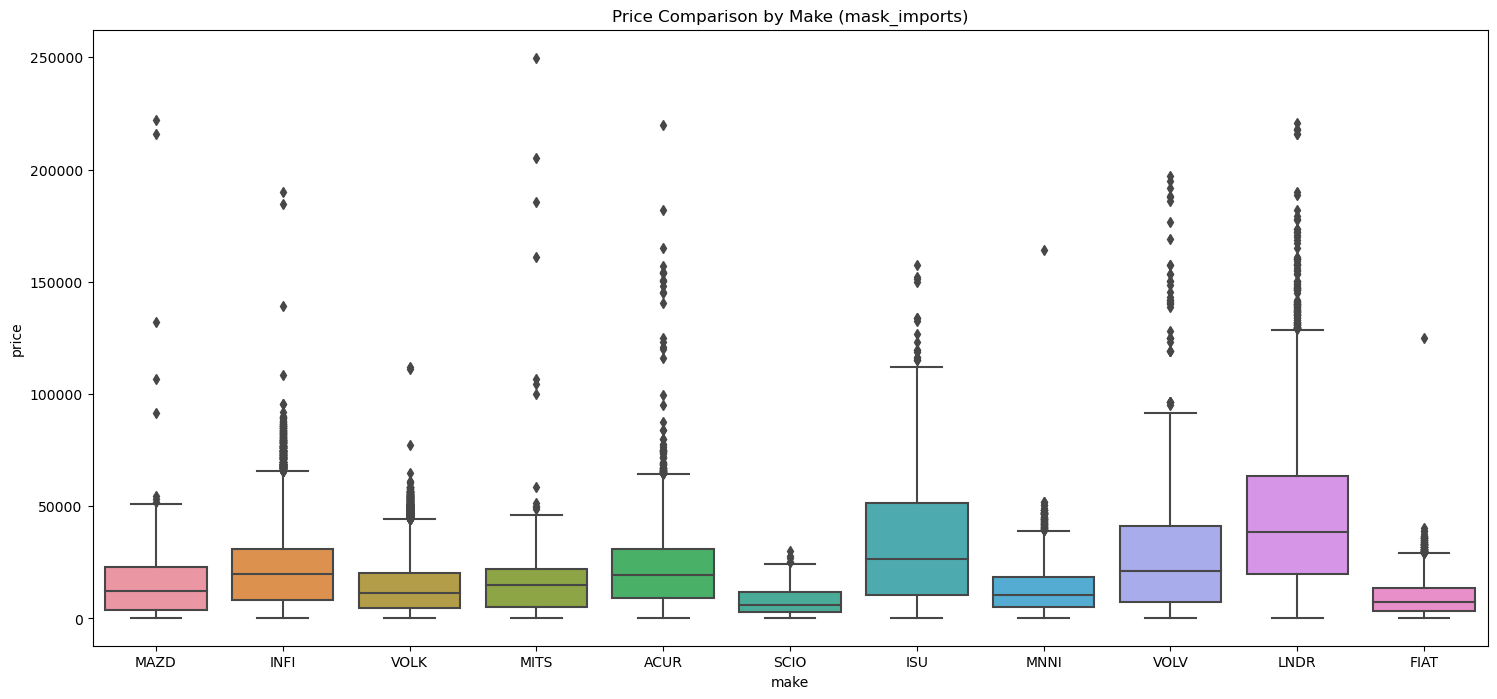

In [7]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_imports])
plt.title("Price Comparison by Make (mask_imports)")
plt.show()

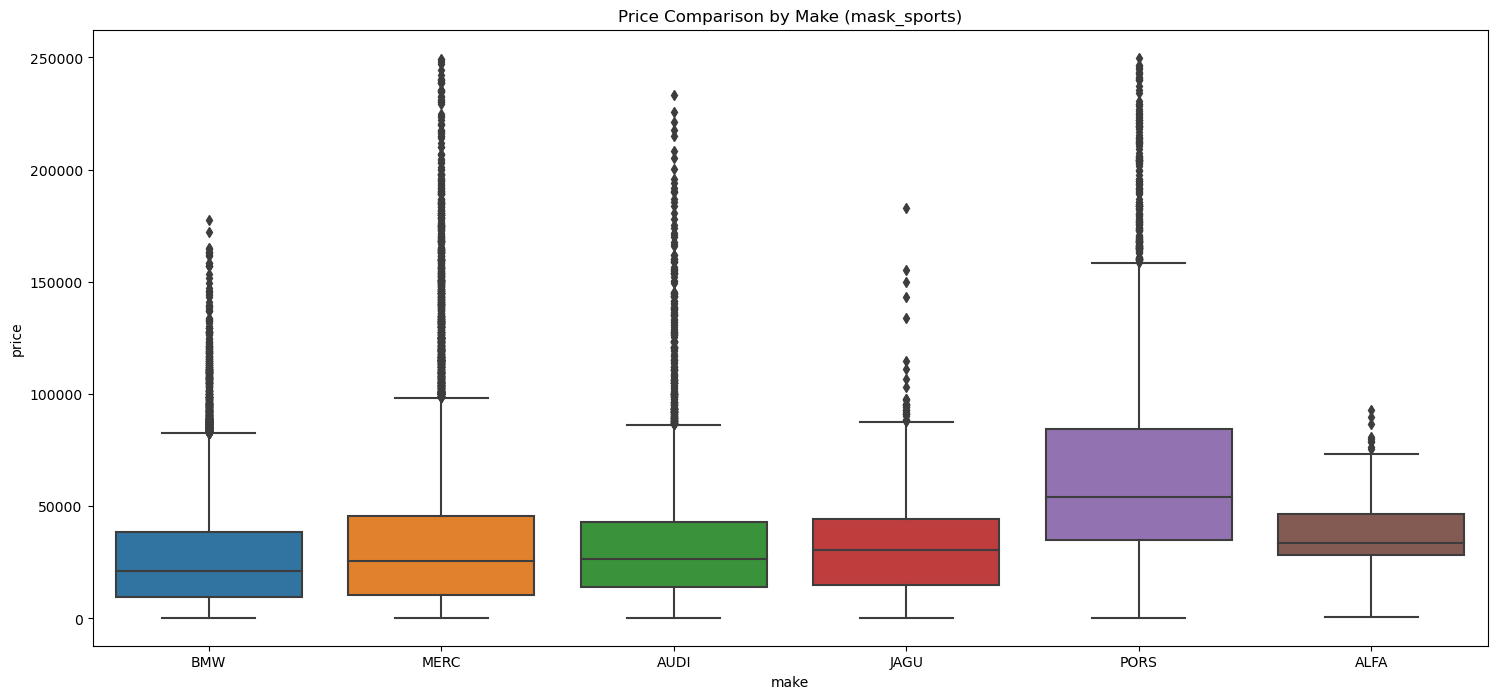

In [8]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_sports])
plt.title("Price Comparison by Make (mask_sports)")
plt.show()

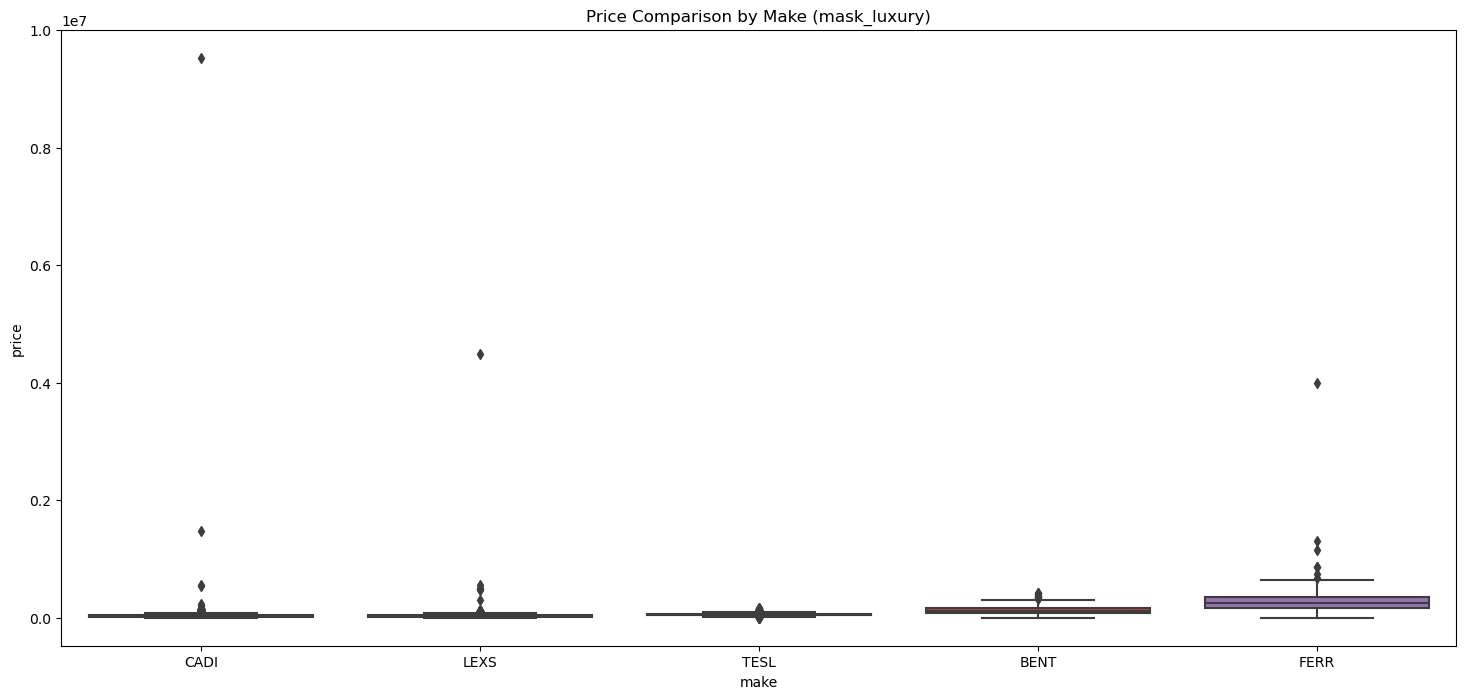

In [9]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_luxury])
plt.title("Price Comparison by Make (mask_luxury)")
plt.show()

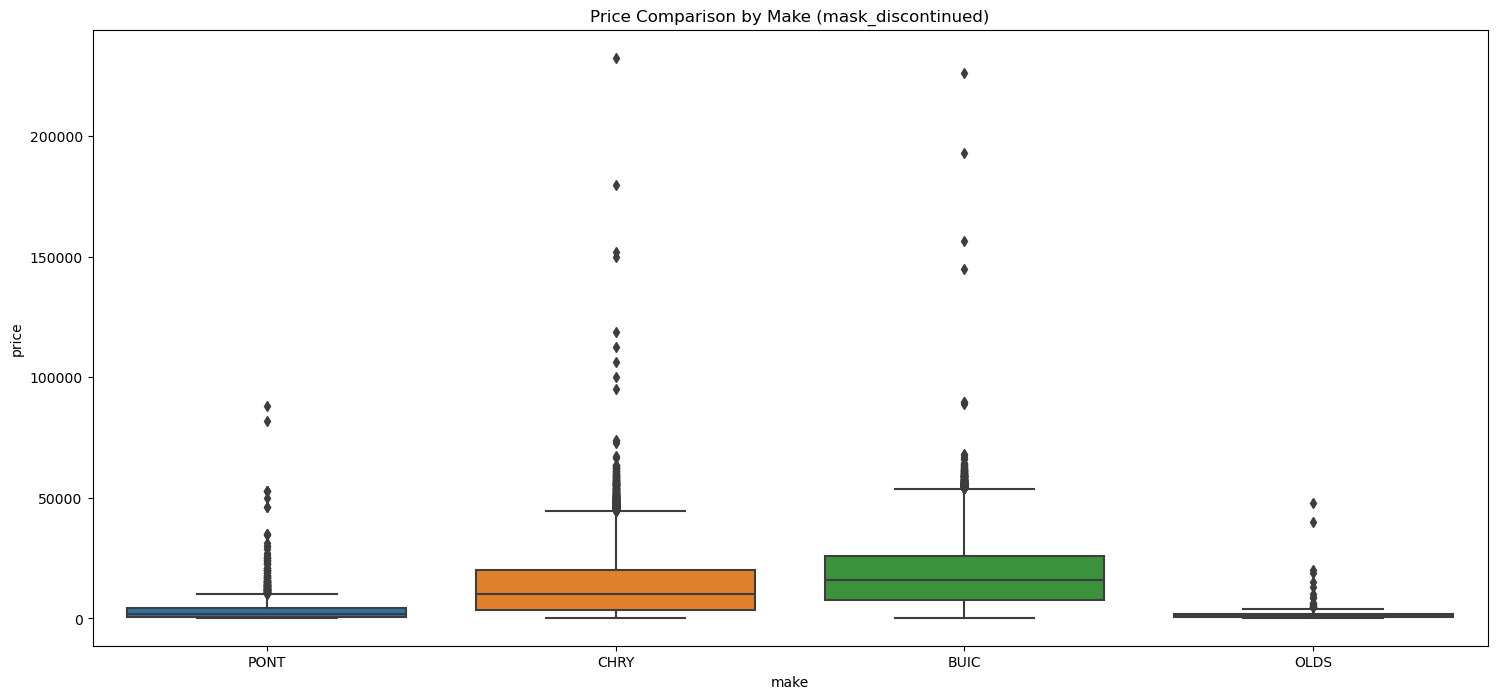

In [10]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_discontinued])
plt.title("Price Comparison by Make (mask_discontinued)")
plt.show()

Number of results: 10920


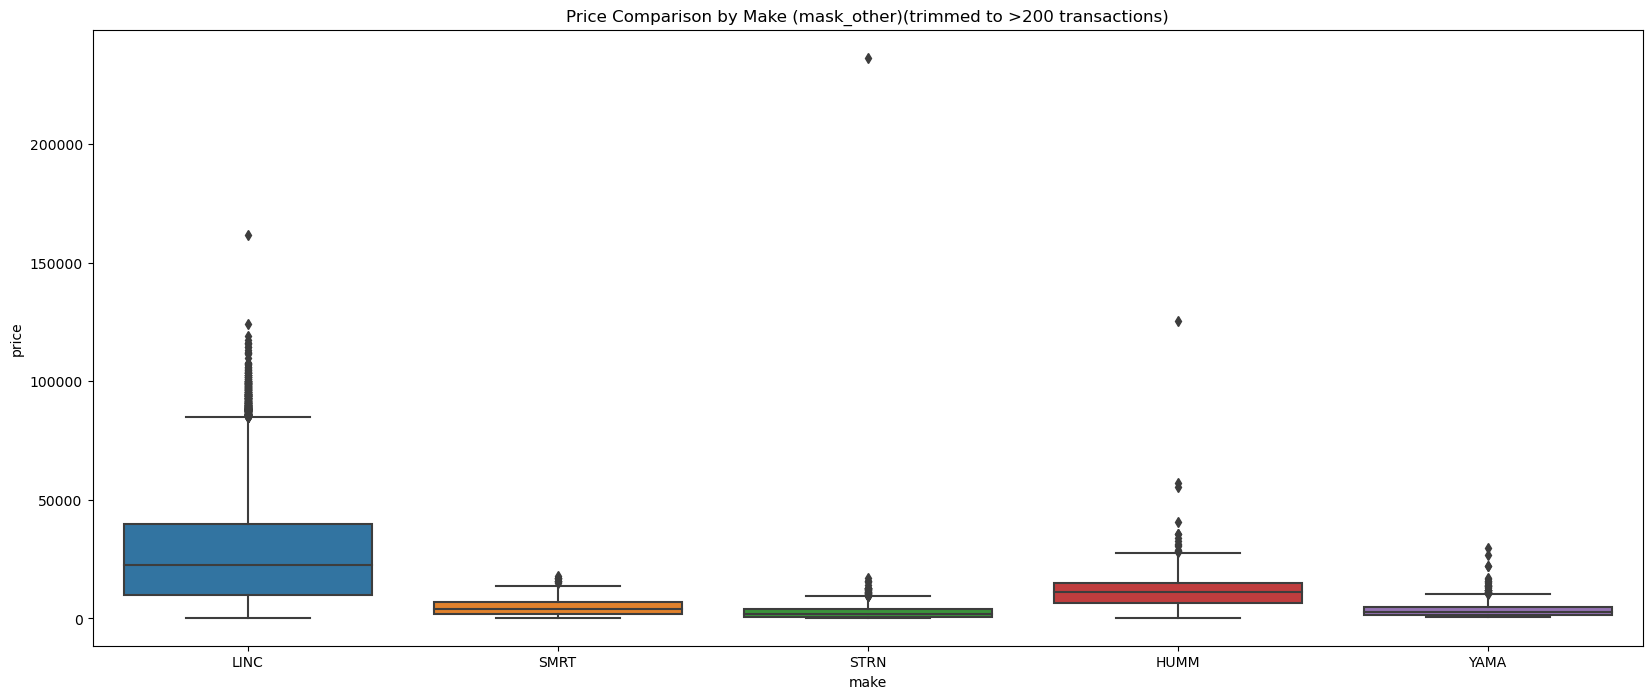

In [11]:
#trimming this down to significant data points (more than 200 transactions)
make_counts = tn_auto_reg_f['make'].value_counts()
mask_make_counts = tn_auto_reg_f['make'].isin(make_counts[make_counts > 200].index)

#boxplot like all the other masks above
plt.figure(figsize=(20,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_other & mask_make_counts])
print("Number of results: " + str(len(tn_auto_reg_f[mask_other & mask_make_counts])))
plt.title("Price Comparison by Make (mask_other)(trimmed to >200 transactions)")
plt.show()

In [12]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model        1        0
1484  CHEV   SLV  51431.0  27446.0
6607  TOYT   4RN  45217.0  30871.0
4503   KIA   SPC  28640.0   2307.0
5381  MERC   SPR  78640.0  70948.0
7172  VOLK   PAS  25259.0  11137.0
4197  JEEP   GDR  59148.0  49243.0
7454  YAMA   YXM  13913.0  13496.0
6167   RAM   3C7  72243.0  41718.0
1646  CHRY   GRA  30893.0  32011.0
6278   RAM   R15  59508.0  24594.0
6459  SUBA   IMP  23366.0  11548.0
3759  HYUN   KNA  30994.0  23153.0
3784  HYUN    SC  42661.0  35990.0
3552  HOND   RAN   6398.0   2500.0
4059  JAGU   EPA  49998.0  32678.0
3387  HOND   C12   4047.0   2536.0
4665  LEXS   RC3  54227.0  30491.0
5572  NISS   1N4  30343.0   8536.0
4928  MAZD   M3H  28631.0   4227.0
1527  CHEV   TRA  34678.0   8131.0
Seeing some models go up on average.


C:\Users\bobbs\AppData\Local\Temp\ipykernel_17796\3464386721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['New', 'Used'])


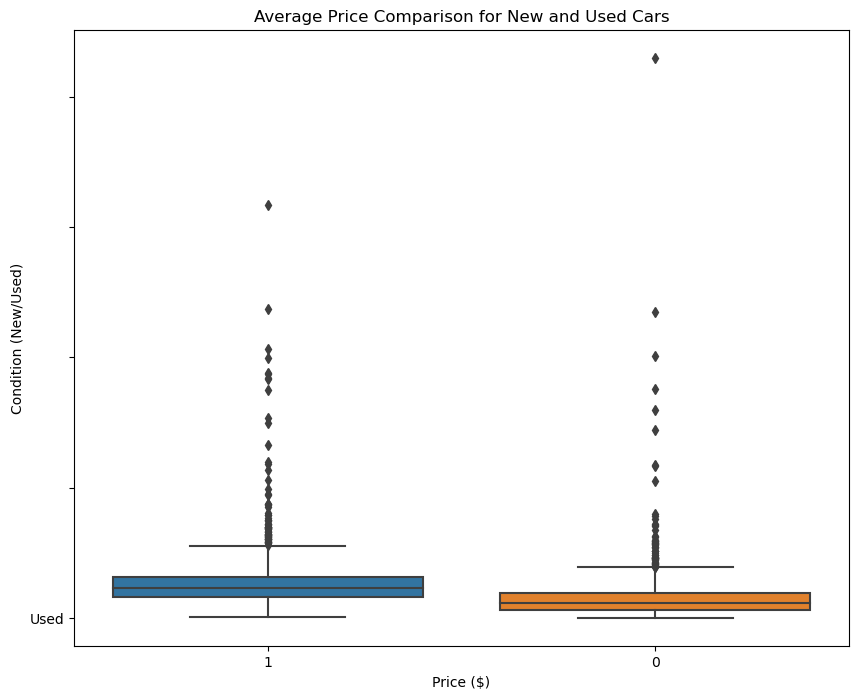

In [13]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,8))

# Plot boxplots for new and used cars side by side
sns.boxplot(data=avg_price_filtered[[1, 0]],  ax=ax)

# Set title and axis labels
ax.set_title("Average Price Comparison for New and Used Cars")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Condition (New/Used)")
ax.set_yticklabels(['New', 'Used'])

# Show plot
plt.show()

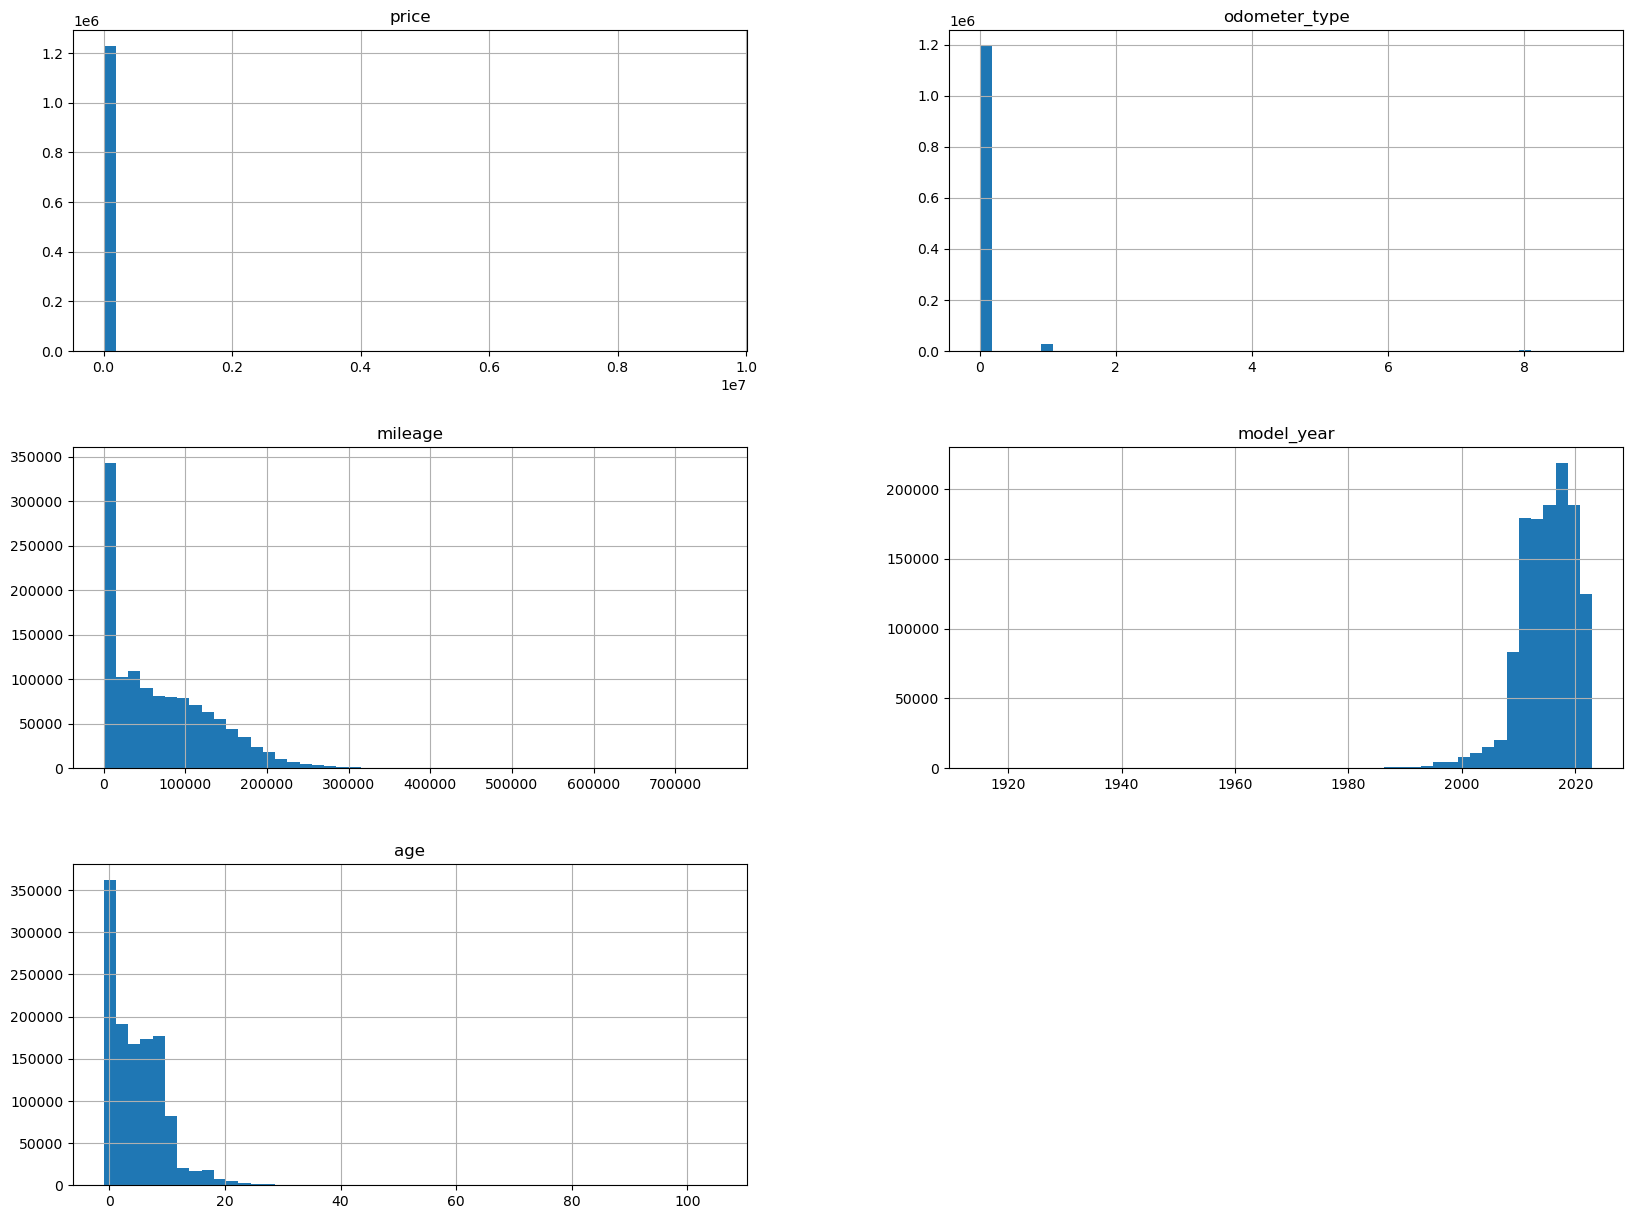

Price, mileage, and age are confirmed by corr analysis to be strong indicators.
Striving for a normal distribution will take some work


In [14]:
tn_auto_reg_f[["price","odometer_type","mileage","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()
print("Price, mileage, and age are confirmed by corr analysis to be strong indicators.")
print("Striving for a normal distribution will take some work")

In [15]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])


Log(age) didn't compute and model year didn't look any different.  Left them alone

Showing transformations on right side that will be prefered in ML algorithm


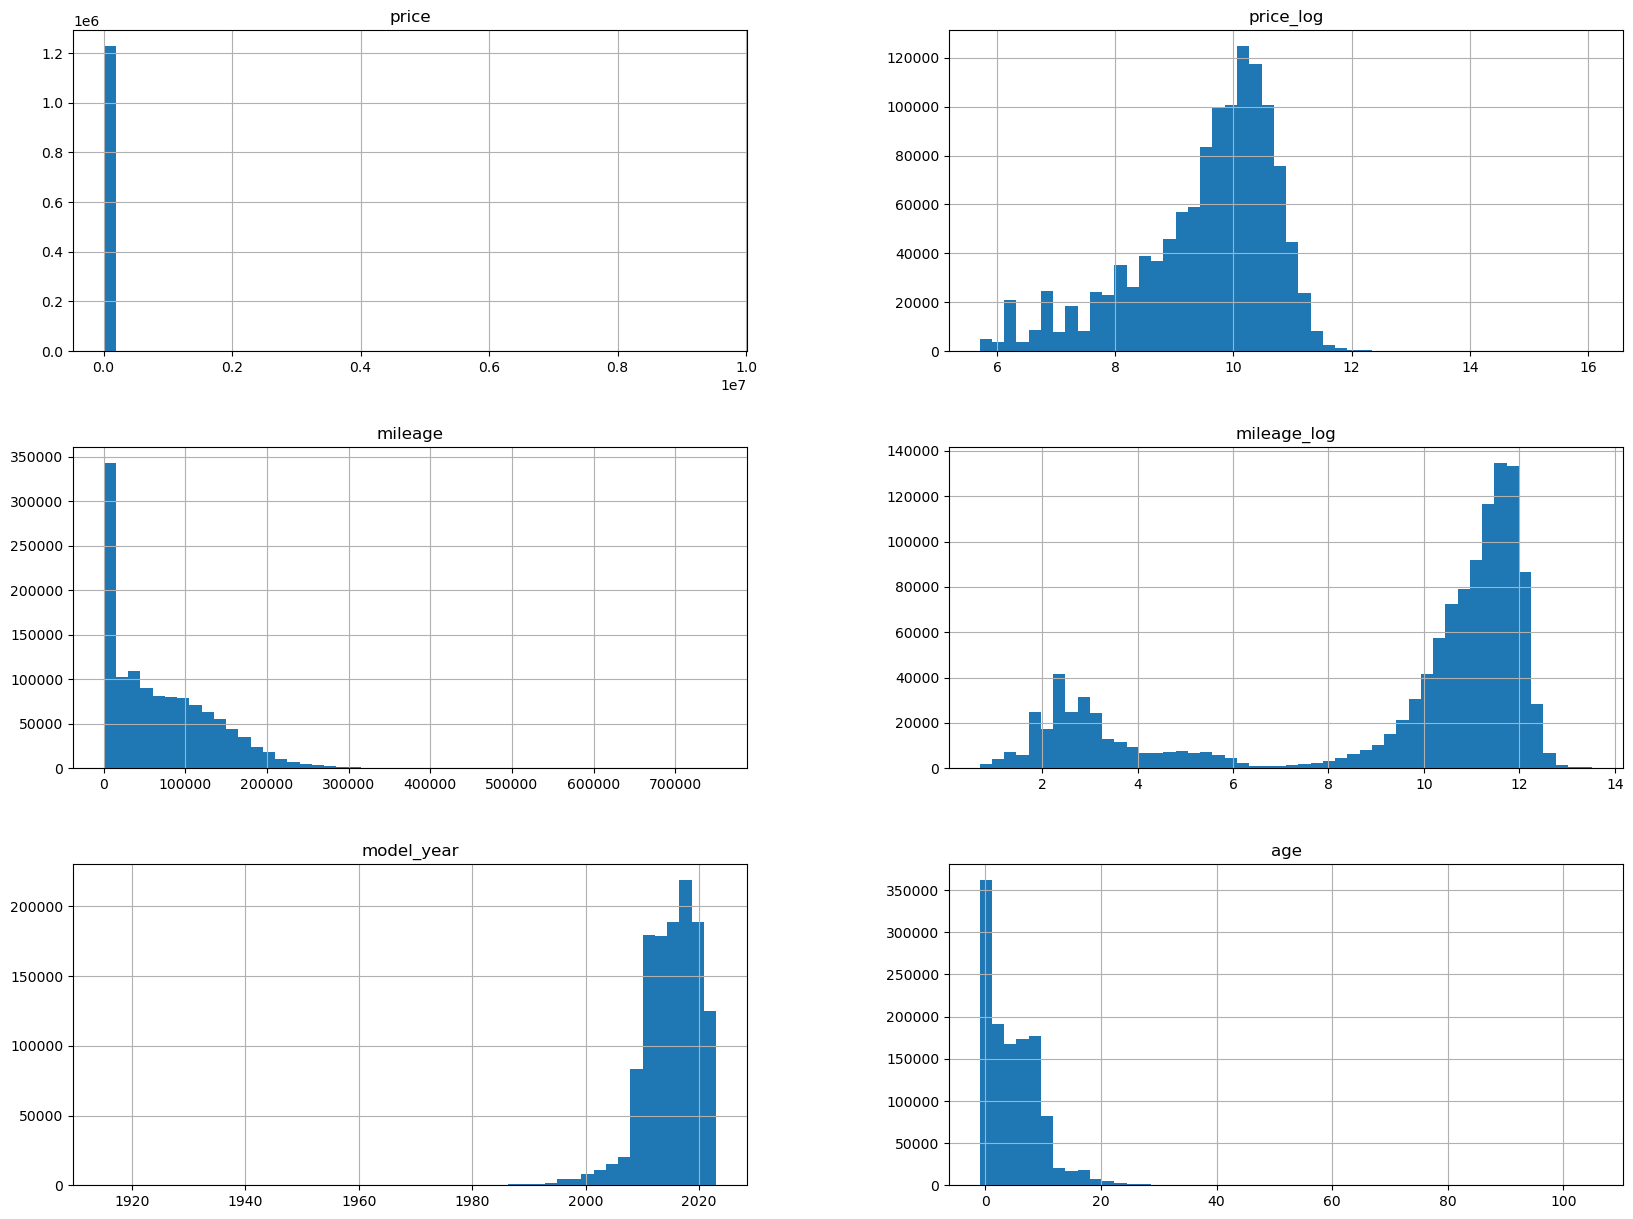

In [16]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
# Sort by VIN
sorted = tn_auto_reg_f.sort_values(by=['vin','title_issue_date'])

# Count the number of records per VIN 
vin_counts = sorted['vin'].value_counts()

# Exclude any cars with less than 2 records
multiple_vins = vin_counts[vin_counts > 3].index

sorted = sorted[sorted['vin'].isin(multiple_vins)] #refactor here? 
print("Number of VINs with more than 1 records:", len(multiple_vins))

Number of VINs with more than 1 records: 1276


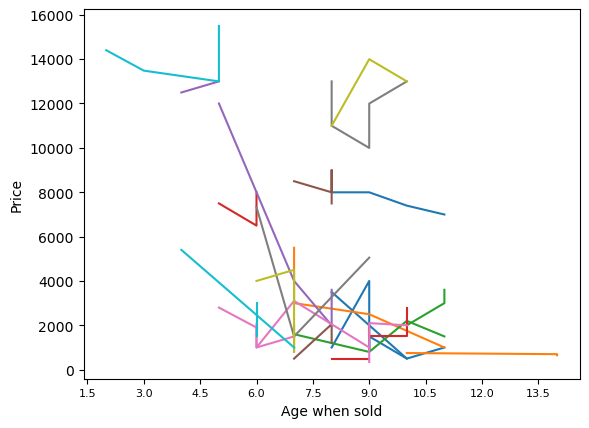

In [19]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Group by VIN and create a dictionary where the keys are the VINs and the values are DataFrames
# containing the purchase date and price for each VIN

# Slice the middle 200 entries
start_idx = 80 #(len(sorted) - 100) // 2
end_idx = start_idx + 100
grouped = sorted.iloc[start_idx:end_idx]
grouped = grouped.groupby('vin')


vin_data = {vin: data[['age', 'price']] for vin, data in grouped}

# Create a color map for the plot
color_map = plt.get_cmap('tab10', len(vin_data))

# Plot each VIN's data as a separate line with a different color
fig, ax = plt.subplots()
for i, (vin, data) in enumerate(vin_data.items()):
    color = color_map(i)

    ax.plot(data['age'], data['price'], label=vin, color=color)

# Format the x-axis to show years and months
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels
    
    # Add a legend and axis labels
#ax.legend()
ax.set_xlabel('Age when sold')
ax.set_ylabel('Price')
plt.show()


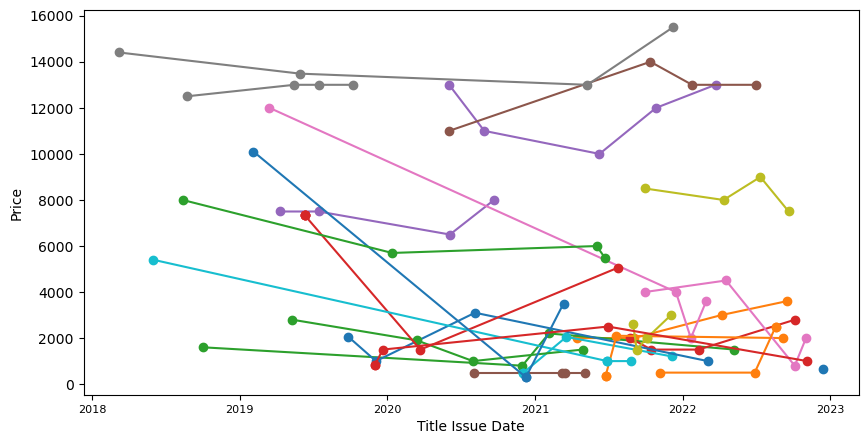

In [22]:
# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots( figsize=(10, 5) )

current_vin = None
current_x = None
current_y = None

for index, row in sorted.iloc[100:200].iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [pd.to_datetime(row['title_issue_date'])]
        current_y = [row['price']]
    else:
        current_x.append(pd.to_datetime(row['title_issue_date']))
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels

ax.set_xlabel('Title Issue Date')
ax.set_ylabel('Price')
plt.show()

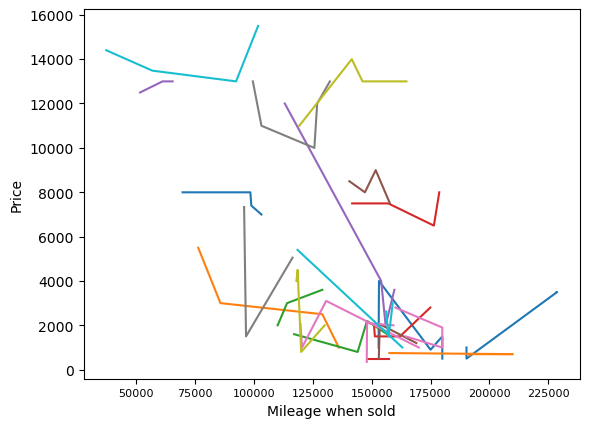

In [20]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Group by VIN and create a dictionary where the keys are the VINs and the values are DataFrames
# containing the purchase date and price for each VIN

# Slice the middle 200 entries
start_idx = 80 #(len(sorted) - 100) // 2
end_idx = start_idx + 100
grouped = sorted.iloc[start_idx:end_idx]
grouped = grouped.groupby('vin')


vin_data = {vin: data[['mileage', 'price']] for vin, data in grouped}

# Create a color map for the plot
color_map = plt.get_cmap('tab10', len(vin_data))

# Plot each VIN's data as a separate line with a different color
fig, ax = plt.subplots()
for i, (vin, data) in enumerate(vin_data.items()):
    color = color_map(i)

    ax.plot(data['mileage'], data['price'], label=vin, color=color)

# Format the x-axis to show years and months
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels
    
    # Add a legend and axis labels
#ax.legend()
ax.set_xlabel('Mileage when sold')
ax.set_ylabel('Price')
plt.show()


In [23]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Analysis completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Analysis completed (total time): 41.0
This section took: 31.0
(in seconds)


            price  mileage   age  new_used_N  type_TRUCK
price        1.00    -0.53 -0.52        0.43        0.19
mileage     -0.53     1.00  0.69       -0.50        0.03
age         -0.52     0.69  1.00       -0.49       -0.01
new_used_N   0.43    -0.50 -0.49        1.00        0.05
type_TRUCK   0.19     0.03 -0.01        0.05        1.00


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

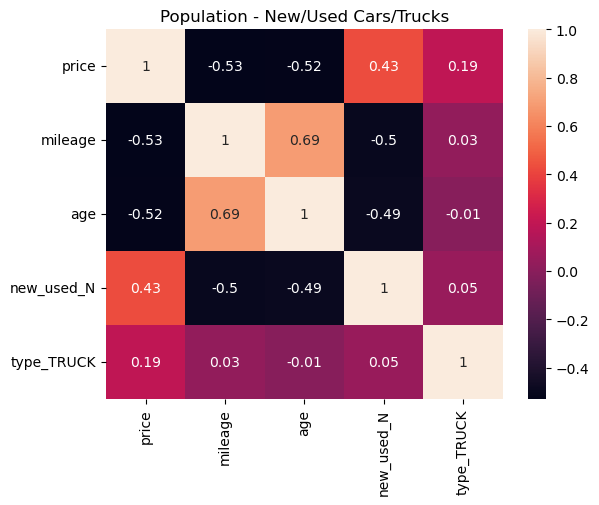

In [17]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price","mileage","age",'new_used_N',"type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)


Below begins the ML Regression 

In [24]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1231111 non-null  object 
 1   price                  1231111 non-null  float64
 2   odometer_type          1231111 non-null  int64  
 3   mileage                1231111 non-null  int64  
 4   county                 1231111 non-null  object 
 5   zip                    1231111 non-null  object 
 6   model_year             1231111 non-null  int64  
 7   make                   1231111 non-null  object 
 8   model                  1231111 non-null  object 
 9   vehicle_type           1231111 non-null  object 
 10  new_used               1231111 non-null  object 
 11  title_issue_date       1231111 non-null  object 
 12  purchase_date          1231111 non-null  object 
 13  age                    1231111 non-null  int64  
 14  make_cat_popular  

In [25]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
dropped = dropped.drop("make", axis=1)
dropped = dropped.drop("model", axis=1)
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)


dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   age                    1231111 non-null  int64  
 1   make_cat_popular       1231111 non-null  int64  
 2   make_cat_imports       1231111 non-null  int64  
 3   make_cat_sports        1231111 non-null  int64  
 4   make_cat_luxury        1231111 non-null  int64  
 5   make_cat_discontinued  1231111 non-null  int64  
 6   make_cat_other         1231111 non-null  int64  
 7   type_AUTO              1231111 non-null  int64  
 8   type_TRUCK             1231111 non-null  int64  
 9   new_used_N             1231111 non-null  int64  
 10  new_used_U             1231111 non-null  int64  
 11  price_log              1231111 non-null  float64
 12  mileage_log            1231111 non-null  float64
dtypes: float64(2), int64(11)
memory usage:

In [26]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)

dropped_shuffled = dropped.sample(frac=1)

train_set, test_set = train_test_split(dropped_shuffled, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
10.642020,0.0,0.0,-0.0
10.306392,0.0,0.0,-0.0
8.540910,0.0,NaN,NaN
10.344545,0.0,0.0,-0.0
9.993768,0.0,0.0,-0.0
10.457209,0.0,NaN,NaN
10.048345,0.0,NaN,NaN
10.335322,0.0,NaN,NaN
10.298919,0.0,0.0,-0.0
10.343054,0.0,NaN,NaN


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [28]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [29]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [30]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984888 entries, 1040945 to 235138
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age                    984888 non-null  int64  
 1   make_cat_popular       984888 non-null  int64  
 2   make_cat_imports       984888 non-null  int64  
 3   make_cat_sports        984888 non-null  int64  
 4   make_cat_luxury        984888 non-null  int64  
 5   make_cat_discontinued  984888 non-null  int64  
 6   make_cat_other         984888 non-null  int64  
 7   type_AUTO              984888 non-null  int64  
 8   type_TRUCK             984888 non-null  int64  
 9   new_used_N             984888 non-null  int64  
 10  new_used_U             984888 non-null  int64  
 11  mileage_log            984888 non-null  float64
dtypes: float64(1), int64(11)
memory usage: 97.7 MB
None


<class 'pandas.core.series.Series'>
Int64Index: 984888 entries, 1040945 to 235138


In [31]:
from sklearn.compose import ColumnTransformer

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","new_used_U","make_cat_popular","make_cat_imports","make_cat_sports","make_cat_luxury",
               "make_cat_discontinued","make_cat_other","type_AUTO","type_TRUCK"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [32]:
registrations_prepared

array([[-2.22451897, -1.00885935,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.838937  , -1.00885935,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.43476468, -0.80618921,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.77146314, -1.00885935,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.40342607, -0.40084893,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.66210442,  0.61250177,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [33]:
registrations_prepared.shape

(984888, 12)

In [34]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 52.0
This section took: 11.0
(in seconds)


In [35]:
import statsmodels.api as sm
X_const = sm.add_constant(registrations_prepared)
OLS_model = sm.OLS(registrations_labels,X_const) 
result = OLS_model.fit()
result.summary() #Erroring here

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                 1.128e+05
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        22:21:50   Log-Likelihood:            -1.1728e+06
No. Observations:              984888   AIC:                         2.346e+06
Df Residuals:                  984876   BIC:                         2.346e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.506e+10   2.94e+10      1.533      0.125   -1.25e+10    1.03e+11
x1            -0.3048      0.002   -170.820      0.000      -0.308      -0.301
x2            -0.7013      0.001   -670.464      0.000      -0.703      -0.699
x3          2.254e+10   1.47e+10      1.532      0.125   -6.29e+09    5.14e+10
x4          2.254e+10   1.47e+10      1.532      0.125   -6.29e+09    5.14e+10
x5         -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x6         -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x7         -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x8         -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x9         -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x10        -8.039e+10   4.67e+10     -1.720      0.085   -1.72e+11    1.12e+10
x11          1.28e+10   6.35e+09      2.016      0.044    3.56e+08    2.52e+10
x12          1.28e+10   6.35e+09      2.016      0.044    3.56e+08    2.52e+10
==============================================================================
Omnibus:                   147933.607   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1353500.662
Skew:                          -0.443   Prob(JB):                         0.00
Kurtosis:                       8.674   Cond. No.                     1.53e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [37]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(984888, 12)
(984888,)


In [38]:
# let's try the full preprocessing pipeline on a few training instances

some_data = registrations_prepared[:5]
some_labels = registrations_labels[:5]

cols = num_attribs + cat_attribs

some_data_df = pd.DataFrame(some_data, columns=cols)

some_data_prepared = full_pipeline.transform(some_data_df)



C:\Users\bobbs\AppData\Local\Temp\ipykernel_17796\4143674071.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  some_labels = registrations_labels[:5]


In [39]:
#Compare prediction against the actual values
print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
print("Labels     :", list(some_labels))

Predictions: [11.0, 11.5, 11.5, 11.3, 11.0]
Labels     : [10.607327362634816, 11.117509692715066, 10.248476986068, 9.944203301412514, 10.85263262128123]


In [40]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 56.0
This section took: 4.0
(in seconds)


In [41]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Root Mean Squared Error:", round(lin_rmse,-2))

Root Mean Squared Error: 0.0


In [42]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

Mean Absolute Error: 0.6


In [43]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

Absolute Percentage Error:


6.6

In [44]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Errors computed (total time): 56.0
This section took: 0.0
(in seconds)


In [45]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

DecisionTreeRegressor(random_state=42)

In [46]:
registrations_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.35756586694682235

In [47]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

1.9095600642102584

In [48]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Tree fit completed (total time): 73.0
This section took: 16.0
(in seconds)


#Slow below here#

In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [50]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.4560957481462825

In [51]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Forest fit completed (total time): 189.0
This section took: 117.0
(in seconds)


In [52]:
#Copy the target into the labels set
test_Y = test_set['price_log'].copy()

#Copy the dropped data into the registrations df 
test_X = test_set.drop('price_log',axis=1).copy()

In [53]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
tree_predictions = tree_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [54]:
from sklearn.metrics import r2_score
r2_score(test_Y, tree_predictions)

-0.8561557166009792

In [55]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
forest_predictions = forest_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [56]:
r2_score(test_Y, forest_predictions)

-0.022366557933614084

In [57]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
lin_predictions = lin_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [58]:
r2_score(test_Y, lin_predictions)

-2.9046886809362807e+21

In [59]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Model prediction checking (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")
print("(_______ End of the first ML Algorithm Section _______)")

mostRecentTime = time.time()

Model prediction checking (total time): 190.0
This section took: 1.0
(in seconds)
(_______ End of the first ML Algorithm Section _______)


Typically an R-squared score ranges from 0-1 with 1 meaning a perfect fit. Negative values indicate a much worse fit in that the average price for all vehicles would be a better fit.  An R-squared score of 0.0526 means that the model explains only 5.26% of the variance in the target variable, which is very low. As that was the top score, it is safe to say the feature set does not sufficently capture the relationship with the target variable.

Thoughts for the next model: model is likely a key feature moreso than brands and groupings of brands.  Any given model of vehicle likely has a maximum value established when sold new, and depreciates with age and mileage. Certain brands may be more likely to increase in price, and scaricity of transactions may be an indicator of rareness. Can drop new_used_U as it is the inverse of new_used_N.   